# Dfsu - 2D interpolation
This notebook demonstrates how to interpolate dfsu data to a grid, how to save the gridded data as dfs2 and geotiff. It also shows how to interpolate dfsu data to another mesh. 

In [1]:
import mikeio

In [2]:
ds = mikeio.read("../tests/testdata/wind_north_sea.dfsu", items="Wind speed")
ds

<mikeio.Dataset>
Geometry: Dfsu2D
Dimensions: (time:6, element:958)
Time: 2017-10-27 00:00:00 - 2017-10-27 05:00:00 (6 records)
Items:
  0:  Wind speed <Wind speed> (meter per sec)

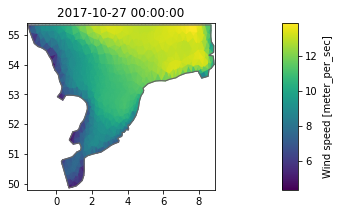

In [3]:
da = ds.Wind_speed
da.plot();

## Interpolate to grid
1. Get an overset grid covering the domain
2. Then interpolate all data to the new grid and plot. 
4. The interpolated data is then saved to a dfs2 file.

In [4]:
g = da.geometry.get_overset_grid(dx=0.1)
g

<mikeio.Grid2D>
x-axis: nx=105 points from x0=-1.52855 to x1=8.87145 with dx=0.1
y-axis: ny=55 points from y0=49.9227 to y1=55.3227 with dy=0.1
Number of grid points: 5775

In [5]:
da_grid = da.interp_like(g)
da_grid

<mikeio.DataArray>
Name: Wind speed
Dimensions: (time:6, y:55, x:105)
Time: 2017-10-27 00:00:00 - 2017-10-27 05:00:00 (6 records)

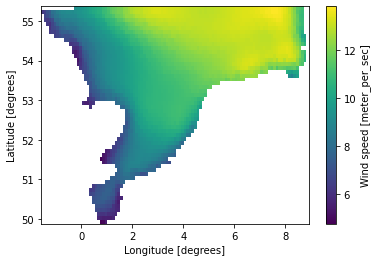

In [6]:
da_grid.plot();

## Save to dfs2 file

In [7]:
da_grid.to_dfs("wind_north_sea_interpolated.dfs2")

![](../images/dfsu_grid_interp.png)

## Save to NetCDF

In [8]:
xr_da = da_grid.to_xarray()
xr_da.to_netcdf("wind_north_sea_interpolated.nc")

![](../images/dfsu_grid_netcdf.png)

## Save to GeoTiff

Install [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) by running this in a command prompt before running this notebook

`conda install -c conda-forge rasterio`

Or if you prefer to avoid conda, here is how:
https://rasterio.readthedocs.io/en/latest/installation.html#windows

In [9]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
# Dcoumentation https://rasterio.readthedocs.io/en/latest/index.html

with rasterio.open(
     'wind.tif',
     'w',
     driver='GTiff',
     height=g.ny,
     width=g.nx,
     count=1,
     dtype=da.dtype,
     crs='+proj=latlong',
     transform=from_origin(g.bbox.left, g.bbox.top, g.dx, g.dy)
     ) as dst:
        dst.write(np.flipud(da_grid[0].to_numpy()), 1) # first time_step
    

![](../images/dfsu_grid_interp_tiff.png)

# Interpolate to other mesh
Interpolate the data from this coarse mesh onto a finer resolution mesh


In [10]:
msh = mikeio.Mesh('../tests/testdata/north_sea_2.mesh')
msh

Flexible Mesh
Number of elements: 2259
Number of nodes: 1296
Projection: LONG/LAT

In [11]:
dsi = da.interp_like(msh)
dsi

<mikeio.DataArray>
Name: Wind speed
Geometry: Dfsu2D
Dimensions: (time:6, element:2259)
Time: 2017-10-27 00:00:00 - 2017-10-27 05:00:00 (6 records)

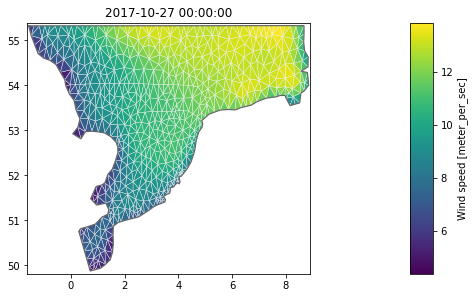

In [12]:
da[0].plot(figsize=(9,7), show_mesh=True);

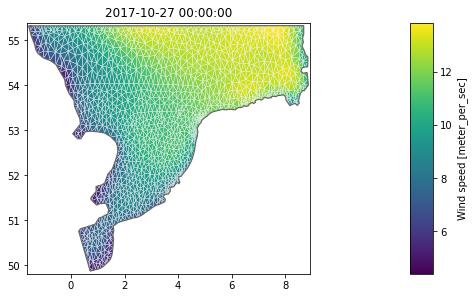

In [13]:
dsi[0].plot(figsize=(9,7), show_mesh=True);

### Note: 3 of the new elements are outside the original mesh and data are therefore NaN by default

In [14]:
nan_elements = msh.element_ids[np.isnan(dsi[0].to_numpy())]
nan_elements

array([ 249,  451, 1546])

In [15]:
da.geometry.contains(msh.element_coordinates[nan_elements,:2])

array([False, False, False])

### We can force extrapolation to avoid the NaN values

In [16]:
dat_interp = da.interp_like(msh, extrapolate=True)

In [17]:
n_nan_elements = np.sum(np.isnan(dat_interp.values))
n_nan_elements

0

## Interpolate scatter data to mesh

We want to interpolate scatter data onto an existing mesh and create a new dfsu with the interpolated data. 

In [18]:
from mikeio.spatial import dist_in_meters
from mikeio.interpolation import get_idw_interpolant

In [19]:
dfs = mikeio.open('../tests/testdata/wind_north_sea.dfsu')

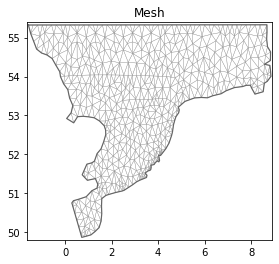

In [20]:
dfs.geometry.plot.mesh();

In [21]:
# scatter data: x,y,value for 4 points
scatter= np.array([[1,50,1], [4, 52, 3], [8, 55, 2], [-1, 55, 1.5]])
scatter

array([[ 1. , 50. ,  1. ],
       [ 4. , 52. ,  3. ],
       [ 8. , 55. ,  2. ],
       [-1. , 55. ,  1.5]])

Let's first try the approx for a single element: 

* calc distance to all interpolation points
* calc IDW interpolatant weights
* Interpolate

In [22]:
dist = dist_in_meters(scatter[:,:2], dfs.element_coordinates[0,:2])
dist

array([4.00139539, 3.18881018, 6.58769411, 2.69722991])

In [23]:
w = get_idw_interpolant(dist, p=2)
w

array([0.19438779, 0.30607974, 0.07171749, 0.42781498])

In [24]:
np.dot(scatter[:,2], w) # interpolated value in element 0

1.8977844597276883

Let's do the same for all points in the mesh and plot in the end

In [25]:
dati = np.zeros((1,dfs.n_elements))
for j in range(dfs.n_elements):
    dist = dist_in_meters(scatter[:,:2], dfs.element_coordinates[j,:2])
    w = get_idw_interpolant(dist, p=2)
    dati[0,j] = np.dot(scatter[:,2], w)

In [26]:
ds = mikeio.Dataset(data=[dati], geometry=dfs.geometry, time=dfs.start_time)
ds

<mikeio.Dataset>
Geometry: Dfsu2D
Dimensions: (time:1, element:958)
Time: 2017-10-27 00:00:00 (time-invariant)
Items:
  0:  Item_1 <Undefined> (undefined)

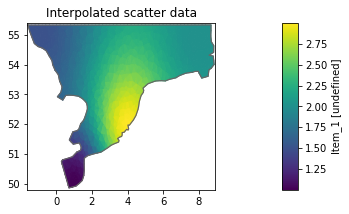

In [27]:
ds[0].plot(title="Interpolated scatter data");

In [28]:
ds.to_dfs("interpolated_scatter.dfsu")

## Clean up

In [29]:
import os

os.remove("wind_north_sea_interpolated.dfs2")
os.remove("wind_north_sea_interpolated.nc")
os.remove("wind.tif")
os.remove("interpolated_scatter.dfsu")